# Basic checks and plots of SDSS SMBH catalogue

In [67]:
from astropy.io import ascii
from astropy.table import 
Table 
import matplotlib.pylab as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

from unions_wl import sample

In [2]:
# Path to data
path_to_data = '../data'

# AGN catalogue name
cat_name = 'SDSS_SMBH_202206.txt'

# Columns in data
# ra, dec in deg
# logM is log of SMBH mass in M_sol
names = ['ra', 'dec', 'z', 'logM']

In [77]:
# Split into mass bins
n_split = 2

In [78]:
# Output information

output_path = './output'

output_fname_base = 'SDSS_SMBH_202206'

In [55]:
n_bin_z_hist = 100

In [3]:
# Read catalogue
dat = ascii.read(f'{path_to_data}/{cat_name}', names=names)

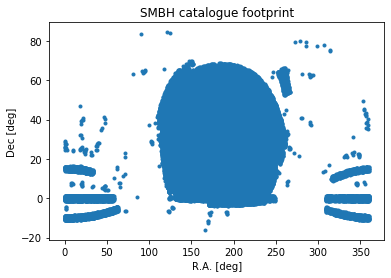

In [4]:
# Plot footprint
plt.plot(dat['ra'], dat['dec'], '.')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
_ = plt.title('SMBH catalogue footprint')

In [5]:
# Mask objects below UNIONS lowest declination 
m = (dat['dec'] > 30)

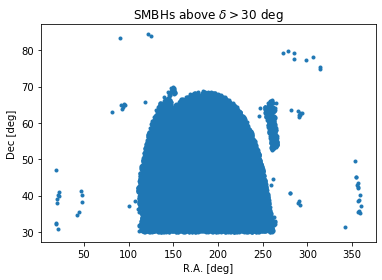

In [6]:
# Plot again
plt.plot(dat['ra'][m], dat['dec'][m], '.')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
_ = plt.title('SMBHs above $\delta > 30$ deg')

In [7]:
# Print number of objects in UNIONS footprint, and total
print(len(np.where(m)[0]), len(dat))

19759 48346


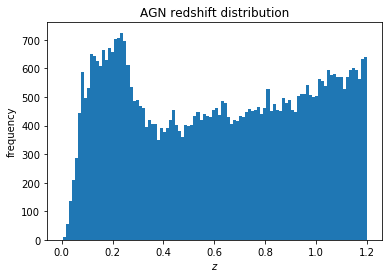

In [48]:
# Redshift distribution
plt.hist(dat['z'], bins=n_bin_z_hist)
plt.xlabel('$z$')
plt.ylabel('frequency')
_ = plt.title('AGN redshift distribution')

Text(0.5, 1.0, 'AGN SMBH mass distribution')

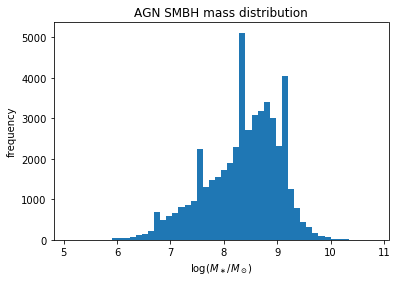

In [9]:
# Mass distribution
plt.hist(dat['logM'], bins=50)
plt.xlabel(r'$\log ( M_\ast / M_\odot )$')
plt.ylabel('frequency')
plt.title('AGN SMBH mass distribution')

In [10]:
# If we want to split the sample into two mass bins, best is maybe at the median
np.median(dat['logM'])

8.5

In [11]:
# To split into more equi-populated bins, compute cumulative distribution function
cdf = ECDF(dat['logM'])

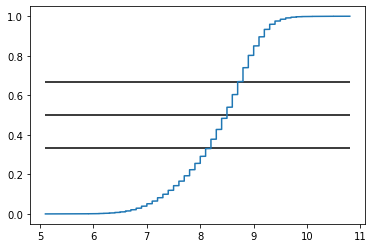

In [12]:
# Plot with some lines to split (e.g. 1/3, 2/3 for split into three samples)
plt.plot(cdf.x, cdf.y, '-')

xmin, xmax = cdf.x[1], cdf.x[-1]
# cdf.x[0] is -infinity

_ = plt.hlines([1/3, 0.5, 2/3], xmin, xmax)

Find mass for split into equi-populated bins

In [14]:
# Split into two (check whether we get median from before)
logM_bounds = sample.y_equi(cdf, n_split)
print(logM_bounds)

[8.5]


In [15]:
# Split into three
y_equi(cdf, 3)

[8.2, 8.7]

In [16]:
# We can play around...
y_equi(cdf, 5)

[7.8, 8.3, 8.6, 8.9]

In [17]:
logM_bounds.insert(0, min(dat['logM']))
logM_bounds.append(max(dat['logM']))

In [18]:
mask_list = []
for idx in range(len(logM_bounds) - 1):
    print(
        f'Creating sample #{idx+1}/{n_split} with'
        + f' {logM_bounds[idx]} <= logM < {logM_bounds[idx + 1]}'
    )
    mask = (
        (dat['logM'] >= logM_bounds[idx])
        & (dat['logM'] < logM_bounds[idx + 1])
    )
    mask_list.append(mask)

Creating sample #1/2 with 5.1 <= logM < 8.5
Creating sample #2/2 with 8.5 <= logM < 10.8


Text(0.5, 1.0, 'AGN SMBH mass distribution')

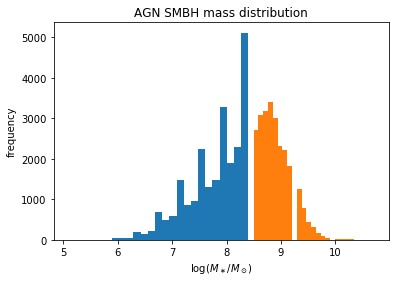

In [19]:
for mask in mask_list:
    plt.hist(dat['logM'][mask], bins=int(50 / n_split))
plt.xlabel(r'$\log ( M_\ast / M_\odot )$')
plt.ylabel('frequency')
plt.title('AGN SMBH mass distribution')

In [49]:
# Adding columns for weight for each sample
for idx in range(len(mask_list)):
    dat[f'w_{idx}'] = np.ones_like(dat['z'])

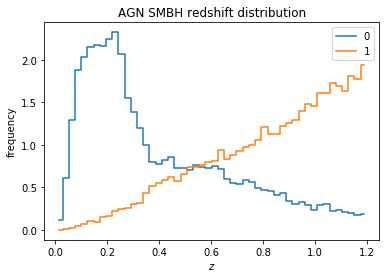

In [58]:
fac = 1.0001
z_min = min(dat['z']) / fac
z_max = max(dat['z']) * fac

for idx, mask in enumerate(mask_list):
        
    z_hist, z_edges = np.histogram(
        dat['z'][mask],
        bins=int(n_bin_z_hist / n_split),
        density=True,
        range=(z_min, z_max),
    )
    z_centres = [(z_edges[i] + z_edges[i+1]) / 2 for i in range(len(z_edges) - 1)]
    
    # Plot histogram
    plt.step(z_centres, z_hist, where='mid', label=idx)
    # The following should produce a near-identical plot
    #plt.hist(dat['z'][mask], bins=int(n_bin_zhist / n_split), alpha=0.5, density=True)
    
    weights = np.ones_like(dat['z'][mask])

    for idz, z in enumerate(dat['z'][mask]):
        w = np.where(z > z_edges)[0]
        if len(w) == 0:
            print('Error:', z)
        else:
            idh = w[-1]
        weights[idz] = 1 / z_hist[idh]

    dat[f'w_{idx}'][mask] = weights
    
plt.xlabel(r'$z$')
plt.ylabel('frequency')
plt.legend()
_ = plt.title('AGN SMBH redshift distribution')

0 0.8358660073355602 0.0059588866537713375
1 0.862886476066549 0.0698596990071913


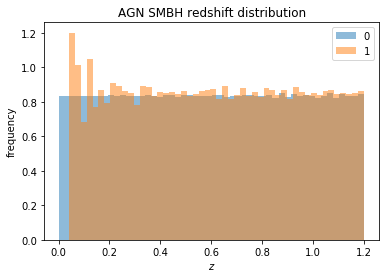

In [63]:
for idx, mask in enumerate(mask_list):
    
    dat_mask = dat[mask]
    
    x = plt.hist(
        dat_mask['z'],
        bins=int(n_bin_z_hist / n_split),
        alpha=0.5,
        density=True,
        weights=dat_mask[f'w_{idx}'],
        label=idx
    )
    print(idx, np.mean(x[0]), np.std(x[0]))
plt.xlabel(r'$z$')
plt.ylabel('frequency')
plt.legend()
_ = plt.title('AGN SMBH redshift distribution')

In [79]:
for idx, mask in enumerate(mask_list):
    t = Table(dat[mask])
    out_name = f'{output_path}/{output_fname_base}_{idx}_n_split_{n_split}.txt'
    print(f'Writing catalogue {out_name}')
    ascii.write(
        t,
        out_name,
        delimiter='\t',
        format='commented_header',
        overwrite=True
    )

Writing catalogue ./output/SDSS_SMBH_202206_0_n_split_2.txt
Writing catalogue ./output/SDSS_SMBH_202206_1_n_split_2.txt
